# Softmax练习
此练习类似于SVM练习。您将：
-为Softmax分类器实现完全矢量化的**损失函数**
-实现其**解析梯度的完全矢量化表达式**
-**使用数值梯度检查您的实现**
-使用验证集**调整学习率和正则化**强度
-**使用**SGD优化**损失函数**
-**可视化**最终学习的权重

In [3]:
import zipfile

# 指定要解压的ZIP文件名
zip_file = 'dlcv.zip'

# 指定解压后的目标文件夹
target_folder = 'test'

# 打开ZIP文件
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # 解压所有文件到目标文件夹
    zip_ref.extractall(target_folder)

print(f'{zip_file} 已成功解压到 {target_folder}')

dlcv.zip 已成功解压到 test


In [23]:
import random
import numpy as np
from dlcv.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    从磁盘加载CIFAR-10数据集，并进行预处理，为线性分类器做好准备。
    这些步骤与我们用于SVM的步骤相同，但浓缩为一个函数。
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'dlcv/datasets/cifar-10-batches-py'
    
    # 清理变量以防止多次加载数据（这可能会导致内存问题）
    try:
        del X_train, y_train
        del X_test, y_test
        print('Clear previously loaded data.')
    except:
        pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # 对数据进行二次采样
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # 预处理：将图像数据重塑为行
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # 规格化数据：减去平均图像
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # 添加偏差维度并转换为列
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# 调用上面的函数来获取我们的数据。
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax 分类器

本节的代码将全部写入“dlcv/classifiers/softmax.py”中。


In [25]:
# 首先用嵌套循环实现简单的softmax loss函数。
# 打开文件dlcv/classifiers/softmax.py并实现softmax_loss_naive函数。

from dlcv.classifiers.softmax import softmax_loss_naive
import time

# 生成一个随机softmax权重矩阵，并使用它来计算损失。
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 作为一个粗略的健全性检查，我们的损失应该接近-log（0.1）。
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.384482
sanity check: 2.302585


**Inline Question 1**

为什么我们期望我们的损失接近-log（0.1）？**简要解释**

$\color{blue}{\textit Your Answer:}$ *1.CIFAR10数据集类别数是10    2.随机初始化 综上两个原因导致正确识别的概率是10%左右* 



In [26]:
# 完成softmax_loss_naive的实现，并实现使用嵌套循环的版本。
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 正如我们对SVM所做的那样，使用数值梯度检查作为调试工具。
# 数值梯度应接近分析梯度。
from dlcv.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# 类似于SVM的情况，使用正则化进行另一个梯度检查
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.340966 analytic: -0.340966, relative error: 4.731841e-08
numerical: 1.353095 analytic: 1.353095, relative error: 1.262125e-08
numerical: -1.798073 analytic: -1.798073, relative error: 2.042364e-08
numerical: -0.668547 analytic: -0.668547, relative error: 1.363230e-08
numerical: -0.341319 analytic: -0.341319, relative error: 2.546463e-08
numerical: 3.083761 analytic: 3.083761, relative error: 1.999924e-08
numerical: 1.688145 analytic: 1.688145, relative error: 1.949723e-08
numerical: -0.256166 analytic: -0.256166, relative error: 2.339295e-07
numerical: 3.713932 analytic: 3.713932, relative error: 7.927980e-10
numerical: -0.146410 analytic: -0.146411, relative error: 1.423771e-07
numerical: 0.132375 analytic: 0.132375, relative error: 2.906828e-07
numerical: 1.041494 analytic: 1.041494, relative error: 2.942029e-08
numerical: -0.906374 analytic: -0.906374, relative error: 2.053911e-08
numerical: 2.467818 analytic: 2.467818, relative error: 2.059745e-08
numerical: 0.119363 

In [27]:
# 既然我们已经有了softmax损失函数及其梯度的简单实现，
# 那么就在softmax_loss_vectorized中实现一个矢量化版本。
# 这两个版本应该计算相同的结果，但矢量化版本应该更快。
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from dlcv.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 正如我们对SVM所做的那样，我们使用Frobenius范数来比较梯度的两个版本。
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.384482e+00 computed in 0.583167s
vectorized loss: 2.384482e+00 computed in 0.006683s
Loss difference: 0.000000
Gradient difference: 0.000000


In [29]:
# 使用验证集来调整超参数（正则化强度和学习率）。你应该在不同的学习率和正则化强度范围内进行实验；
# 如果你很小心，你应该能够在验证集上获得超过0.35的分类准确度。

from dlcv.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [2e-7, 0.75e-7,1.5e-7, 1.25e-7]
regularization_strengths = [3e4, 3.25e4, 3.5e4, 3.75e4]
################################################################################
# TODO:                                                                        #
# 使用验证集设置学习率和正则化强度。这应该与您对SVM所做的验证相同；                        #
# 将经过最佳训练的softmax分类器保存在best_softmax中。                                #
################################################################################

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
      for reg in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=reg,num_iters=500, verbose=False)
        y_train_pre = softmax.predict(X_train)
        y_train_acc = np.mean(y_train == y_train_pre)
        y_val_pre = softmax.predict(X_val)
        y_val_acc = np.mean(y_val == y_val_pre)
        results[(lr,reg)] = (y_train_acc,y_val_acc)
        if(y_val_acc > best_val):
            best_val = y_val_acc
            best_softmax = softmax
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****    
# Print out results.
for lr, reg in sorted(results):
    train_acc, val_acc = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_acc, val_acc))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 7.500000e-08 reg 3.000000e+04 train accuracy: 0.344286 val accuracy: 0.352000
lr 7.500000e-08 reg 3.250000e+04 train accuracy: 0.339776 val accuracy: 0.351000
lr 7.500000e-08 reg 3.500000e+04 train accuracy: 0.341592 val accuracy: 0.364000
lr 7.500000e-08 reg 3.750000e+04 train accuracy: 0.340633 val accuracy: 0.351000
lr 1.250000e-07 reg 3.000000e+04 train accuracy: 0.345612 val accuracy: 0.359000
lr 1.250000e-07 reg 3.250000e+04 train accuracy: 0.337082 val accuracy: 0.350000
lr 1.250000e-07 reg 3.500000e+04 train accuracy: 0.338122 val accuracy: 0.341000
lr 1.250000e-07 reg 3.750000e+04 train accuracy: 0.339286 val accuracy: 0.354000
lr 1.500000e-07 reg 3.000000e+04 train accuracy: 0.342837 val accuracy: 0.353000
lr 1.500000e-07 reg 3.250000e+04 train accuracy: 0.347510 val accuracy: 0.365000
lr 1.500000e-07 reg 3.500000e+04 train accuracy: 0.332878 val accuracy: 0.343000
lr 1.500000e-07 reg 3.750000e+04 train accuracy: 0.340898 val accuracy: 0.358000
lr 2.000000e-07 reg 3.000000

In [31]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.343000


**Inline Question 2** - *True or False*

假设总训练损失被定义为所有训练示例中每个数据点损失的总和。
可以向训练集中添加一个新的数据点，使SVM损失保持不变，但Softmax分类器损失的情况并非如此。

$\color{blue}{\textit Your Answer:向训练集中添加一个新的数据点，SVM的损失可以保持不变，但Softmax分类器的损失通常会发生变化。}$


$\color{blue}{\textit Your Explanation:SVM损失函数通常是合页损失，关注点在于保持正确类别的数据点的分数高于其他类别的数据点，直到超过某个阈值。对于一个已经正确分类的数据点，只要它的间隔没有超出某个阈值，就可以被添加到datasetrain,并且损失保持不变；softmax分类器使用交叉熵损失，每个类别的概率分布来计算损失。新增的点可能会改变每个类别的概率分布，导致更高的损失也是有可能的。}$



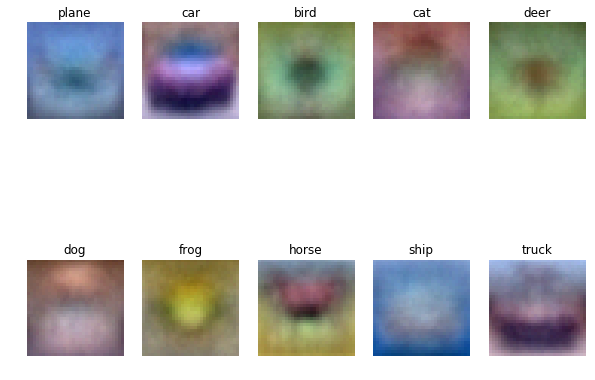

In [32]:
# 可视化每个类的学习权重
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])